In [1]:
import numpy as np, prjlib, plottools as pl, healpy as hp, pickle, curvedsky, tools_delens, misctools, tools_lens, tools_delens, binning as bn
from matplotlib.pyplot import *
import warnings
warnings.filterwarnings("ignore")

In [2]:
pobj = prjlib.analysis_init(t='la',freq='com',fltr='none',ntype='base_roll50')
qobj = tools_lens.init_qobj(pobj.stag,False,rlmin=300,rlmax=4096,qlist=['TT','TE','EE','EB'])
Pobj = prjlib.analysis_init(t='la',freq='com',fltr='none',ntype='base_iso_roll50')
Qobj = tools_lens.init_qobj(Pobj.stag,False,rlmin=300,rlmax=4096,qlist=['TT','TE','EE','EB'])
nside, lmax = 2048, 2048

In [3]:
# load windows
W, __ = prjlib.window('la',ascale=5.,nside=2048) # apodized window already multiplied to phi alms
M = W/(W+1e-30)
wn = prjlib.wfac('la')

In [4]:
# noise variance of phi^rec
nkk = pickle.load(open(qobj.f['TT'].nkmap,"rb"))

In [5]:
# input phi for cross
iklm = prjlib.load_input_plm(pobj.fpalm[1],2048,ktype='k')

In [6]:
# phi^iso
Kalm = tools_lens.load_klms(Qobj.f['TT'].alm[1],lmax)

In [8]:
# phi^rec
kalm = tools_lens.load_klms(qobj.f['TT'].alm[1],lmax,fmlm=qobj.f['TT'].mfb[1])
kalm[:10] = 0.

In [9]:
# phi^kcinv
walm = pickle.load(open(qobj.f['TT'].walm[1],"rb"))[0]

In [10]:
Iwlm = curvedsky.utils.mulwin(Kalm,W)  # W x phi^iso 
Imlm = curvedsky.utils.mulwin(Kalm,M)  # M x phi^iso
knlm = curvedsky.utils.mulwin(kalm,1./(nkk**0.5+1e-30))  # 1/N x phi^rec

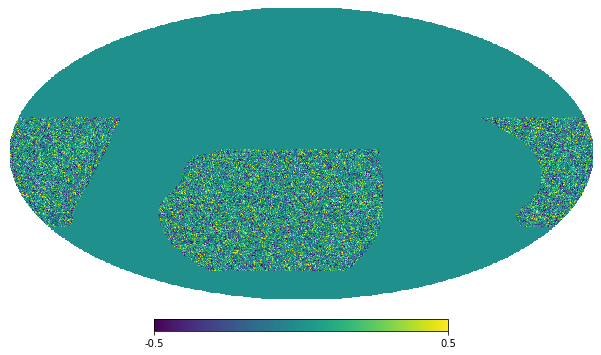

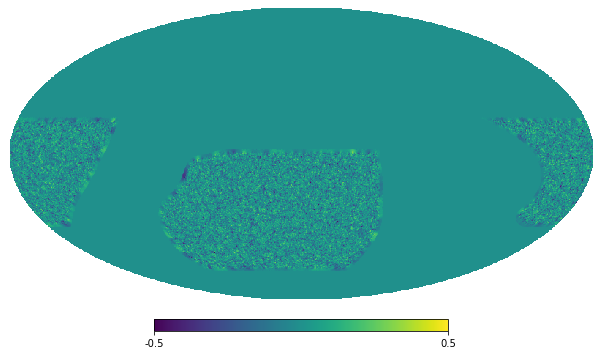

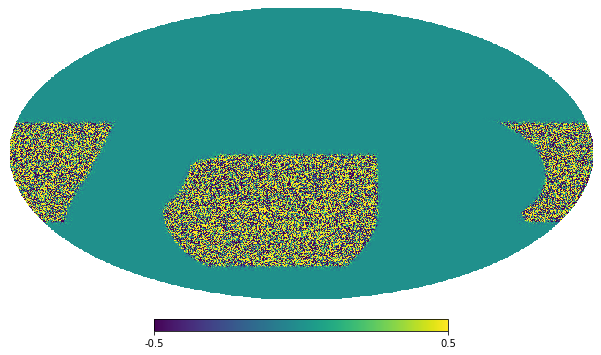

In [11]:
# show maps
prjlib.view_map_from_alm(iklm,nside,lmax,min=-.5,max=.5,W=M/wn[0])
prjlib.view_map_from_alm(walm,nside,lmax,min=-.5,max=.5,W=M/wn[0])
prjlib.view_map_from_alm(kalm,nside,lmax,min=-.5,max=.5,W=M/wn[0])

#### Correlation coefficients with input kappa

The presence of the apodization edge seems to reduce the correlation. The method to avoid this is to use C-inv maps for reconstruction

In [12]:
# compute correlation coefficients
rlr = curvedsky.utils.alm2rho(lmax,iklm,kalm)
rlw = curvedsky.utils.alm2rho(lmax,iklm,walm)
rlR = curvedsky.utils.alm2rho(lmax,iklm,Iwlm)
rlM = curvedsky.utils.alm2rho(lmax,iklm,Imlm)
rln = curvedsky.utils.alm2rho(lmax,iklm,knlm)

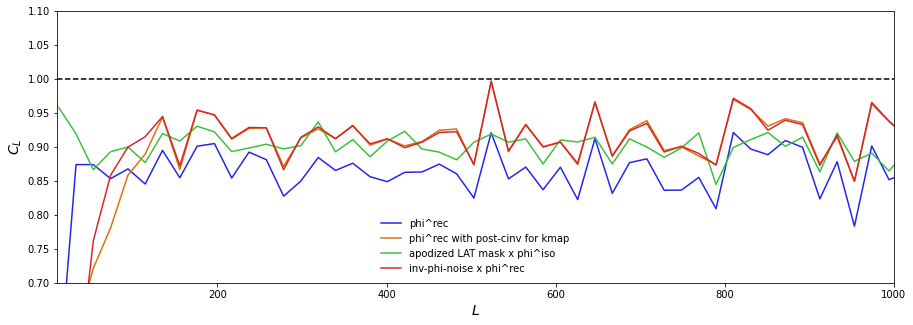

In [14]:
# plot
mb = bn.multipole_binning(100,lmin=2,lmax=2048)
ref = bn.binning(rlM,mb)
pl.plot_1dstyle(fsize=[15,5],xmin=10,xmax=1000,ymin=0.7,ymax=1.1)
plot(mb.bc,bn.binning(rlr,mb)/ref,label='phi^rec')
plot(mb.bc,bn.binning(rlw,mb)/ref,label='phi^rec with post-cinv for kmap')
plot(mb.bc,bn.binning(rlR,mb)/ref,label='apodized LAT mask x phi^iso ')
plot(mb.bc,bn.binning(rln,mb)/ref,label='inv-phi-noise x phi^rec ')
legend()
axhline(1,color='k',ls='--')